<a href="https://colab.research.google.com/github/NguyenDong143/Python-for-Finance-Investment-Fundamentals-Data-Analytics/blob/master/Predict_data_70_20_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Xây dựng Mô hình ANN



In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from google.colab import files
import io

# Thiết lập thẩm mỹ cho biểu đồ
plt.style.use('ggplot')
%matplotlib inline

In [152]:
# Đọc dữ liệu
df = pd.read_csv('/content/fgi_historical.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Lọc bỏ các cột không phải dạng số (như 'state') và chỉ giữ lại 'fgi' và 'close'
df_numeric = df[['close', 'fgi']]
print(f"Dữ liệu có {df_numeric.shape[0]} dòng và {df_numeric.shape[1]} cột đặc trưng số.")
df_numeric.head(3)

Dữ liệu có 1499 dòng và 2 cột đặc trưng số.


,close,fgi
0,966.67,60.54
1,965.14,47.54
2,955.79,49.08


In [153]:
def create_sliding_window(data, window_size=10):
    X, y = [], []
    # Chúng ta dự báo cột 'close' (VN-Index)
    # Target là giá của ngày tiếp theo (index + window_size)
    close_idx = data.columns.get_loc('close')

    data_values = data.values
    for i in range(len(data_values) - window_size):
        # Lấy toàn bộ các đặc trưng trong cửa sổ (window_size ngày)
        window = data_values[i : i + window_size]
        X.append(window.flatten()) # Phẳng hóa để đưa vào mạng ANN (Dense layers)
        y.append(data_values[i + window_size, close_idx])

    return np.array(X), np.array(y)

# Cấu hình: Nhìn lại 10 ngày để dự báo ngày thứ 11
WINDOW_SIZE = 10
X_raw, y_raw = create_sliding_window(df_numeric, window_size=WINDOW_SIZE)

print(f"Kích thước tập X: {X_raw.shape}")
print(f"Kích thước tập y: {y_raw.shape}")

Kích thước tập X: (1489, 20)
Kích thước tập y: (1489,)


In [154]:
# Chia Train/Test (80/20) theo trình tự thời gian
split = int(len(X_raw) * 0.8)
X_train_unscaled, X_test_unscaled = X_raw[:split], X_raw[split:]
y_train_unscaled, y_test_unscaled = y_raw[:split], y_raw[split:]

# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train_unscaled)
X_test = scaler_X.transform(X_test_unscaled)

y_train = scaler_y.fit_transform(y_train_unscaled.reshape(-1, 1))
y_test = scaler_y.transform(y_test_unscaled.reshape(-1, 1))

In [155]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Sử dụng Adam optimizer và Huber loss (chống nhiễu tốt cho dữ liệu chứng khoán)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='huber')

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,641 (190.00 KB)

 Trainable params: 48,641 (190.00 KB)

 Non-trainable params: 0 (0.00 B)

In [156]:
print("Bắt đầu huấn luyện...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Bắt đầu huấn luyện...
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0410 - val_loss: 0.0029
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0047 - val_loss: 0.0057
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032 - val_loss: 0.0094
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0100
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0078
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0104
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0138
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0100
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0122
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0108


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

--- KẾT QUẢ ĐÁNH GIÁ ---
RMSE: 102.86 điểm
MAE: 93.52 điểm
R2 Score: 0.7098


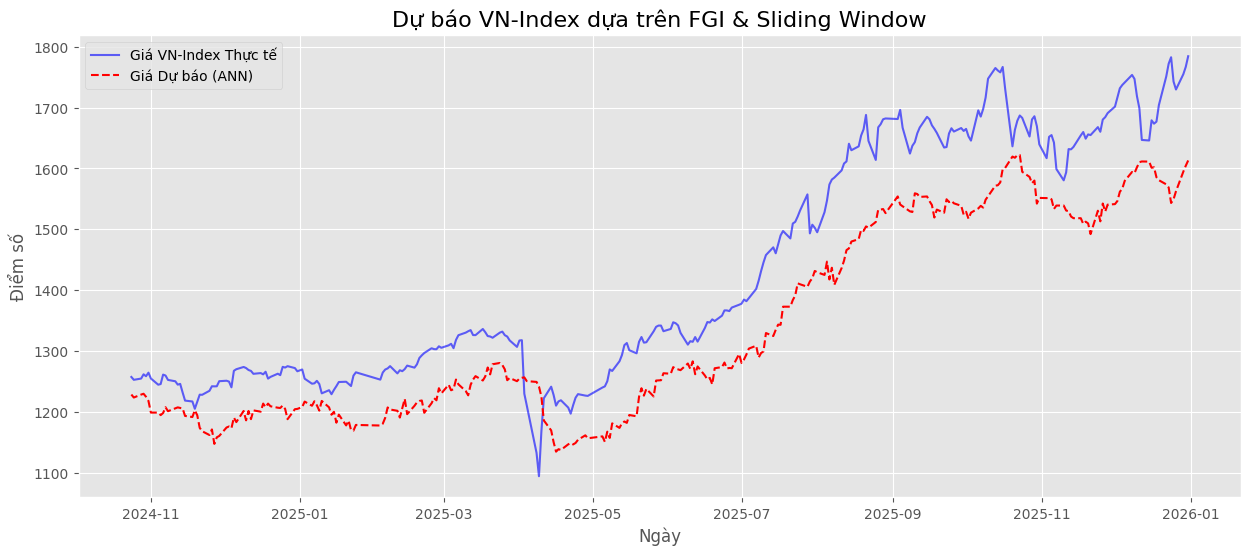

In [157]:
# Dự báo
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = y_test_unscaled

# Tính toán các chỉ số
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"\n--- KẾT QUẢ ĐÁNH GIÁ ---")
print(f"RMSE: {rmse:.2f} điểm")
print(f"MAE: {mae:.2f} điểm")
print(f"R2 Score: {r2:.4f}")

# Vẽ biểu đồ kết quả
plt.figure(figsize=(15, 6))
dates = df['date'].iloc[split + WINDOW_SIZE:].values
plt.plot(dates, y_actual, label='Giá VN-Index Thực tế', color='blue', alpha=0.6)
plt.plot(dates, y_pred, label='Giá Dự báo (ANN)', color='red', linestyle='--')
plt.title("Dự báo VN-Index dựa trên FGI & Sliding Window", fontsize=16)
plt.xlabel("Ngày")
plt.ylabel("Điểm số")
plt.legend()
plt.show()

## Xây dựng Mô hình LSTM/GRU

### Subtask:
Thay đổi kiến trúc mạng từ ANN sang sử dụng các lớp LSTM hoặc GRU và điều chỉnh quá trình chuẩn hóa dữ liệu cho phù hợp với đầu vào 3 chiều của mô hình tuần tự.



In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from google.colab import files
import io

# Thiết lập thẩm mỹ cho biểu đồ
plt.style.use('ggplot')
%matplotlib inline

In [159]:
# Đọc dữ liệu
df = pd.read_csv('/content/fgi_historical.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Lọc bỏ các cột không phải dạng số (như 'state') và chỉ giữ lại 'fgi' và 'close'
df_numeric = df[['close', 'fgi']]
print(f"Dữ liệu có {df_numeric.shape[0]} dòng và {df_numeric.shape[1]} cột đặc trưng số.")
df_numeric.head(3)

Dữ liệu có 1499 dòng và 2 cột đặc trưng số.


,close,fgi
0,966.67,60.54
1,965.14,47.54
2,955.79,49.08


In [160]:
def create_sliding_window(data, window_size=10):
    X, y = [], []
    # Chúng ta dự báo cột 'close' (VN-Index)
    # Target là giá của ngày tiếp theo (index + window_size)
    close_idx = data.columns.get_loc('close')

    data_values = data.values
    for i in range(len(data_values) - window_size):
        # Lấy toàn bộ các đặc trưng trong cửa sổ (window_size ngày)
        window = data_values[i : i + window_size]
        X.append(window) # Đảm bảo X có dạng 3 chiều (samples, timesteps, features)
        y.append(data_values[i + window_size, close_idx])

    return np.array(X), np.array(y)

# Cấu hình: Nhìn lại 10 ngày để dự báo ngày thứ 11
WINDOW_SIZE = 10
X_raw, y_raw = create_sliding_window(df_numeric, window_size=WINDOW_SIZE)

print(f"Kích thước tập X: {X_raw.shape}")
print(f"Kích thước tập y: {y_raw.shape}")

Kích thước tập X: (1489, 10, 2)
Kích thước tập y: (1489,)


In [161]:
import numpy as np

# Chia Train/Test (80/20) theo trình tự thời gian
split = int(len(X_raw) * 0.8)
X_train_unscaled, X_test_unscaled = X_raw[:split], X_raw[split:]
y_train_unscaled, y_test_unscaled = y_raw[:split], y_raw[split:]

# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Đối với X (đầu vào 3D: samples, timesteps, features)
# Flatten X_train_unscaled và X_test_unscaled cho scaler (cần 2D: (samples * timesteps, features))
X_train_reshaped = X_train_unscaled.reshape(-1, X_train_unscaled.shape[-1])
X_test_reshaped = X_test_unscaled.reshape(-1, X_test_unscaled.shape[-1])

X_train_scaled_flat = scaler_X.fit_transform(X_train_reshaped)
X_test_scaled_flat = scaler_X.transform(X_test_reshaped)

# Reshape lại X_train và X_test về dạng 3D ban đầu (samples, timesteps, features)
X_train = X_train_scaled_flat.reshape(X_train_unscaled.shape)
X_test = X_test_scaled_flat.reshape(X_test_unscaled.shape)

# Đối với y (đầu ra 1D/2D: samples, 1)
y_train = scaler_y.fit_transform(y_train_unscaled.reshape(-1, 1))
y_test = scaler_y.transform(y_test_unscaled.reshape(-1, 1))

print(f"X_train shape after scaling: {X_train.shape}")
print(f"X_test shape after scaling: {X_test.shape}")
print(f"y_train shape after scaling: {y_train.shape}")
print(f"y_test shape after scaling: {y_test.shape}")

X_train shape after scaling: (1191, 10, 2)
X_test shape after scaling: (298, 10, 2)
y_train shape after scaling: (1191, 1)
y_test shape after scaling: (298, 1)


In [162]:
from tensorflow.keras.layers import LSTM # Import LSTM layer

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Sử dụng Adam optimizer và Huber loss (chống nhiễu tốt cho dữ liệu chứng khoán)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='huber')

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

In [163]:
print("Bắt đầu huấn luyện...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Bắt đầu huấn luyện...
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0730 - val_loss: 4.6131e-04
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0050 - val_loss: 4.8575e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0030 - val_loss: 2.8783e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025 - val_loss: 3.3950e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025 - val_loss: 2.2168e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0021 - val_loss: 9.6203e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 3.9509e-04
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - val_loss: 2.2706e-04
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017 - val_loss: 2.151

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

--- KẾT QUẢ ĐÁNH GIÁ ---
RMSE: 32.98 điểm
MAE: 23.41 điểm
R2 Score: 0.9702


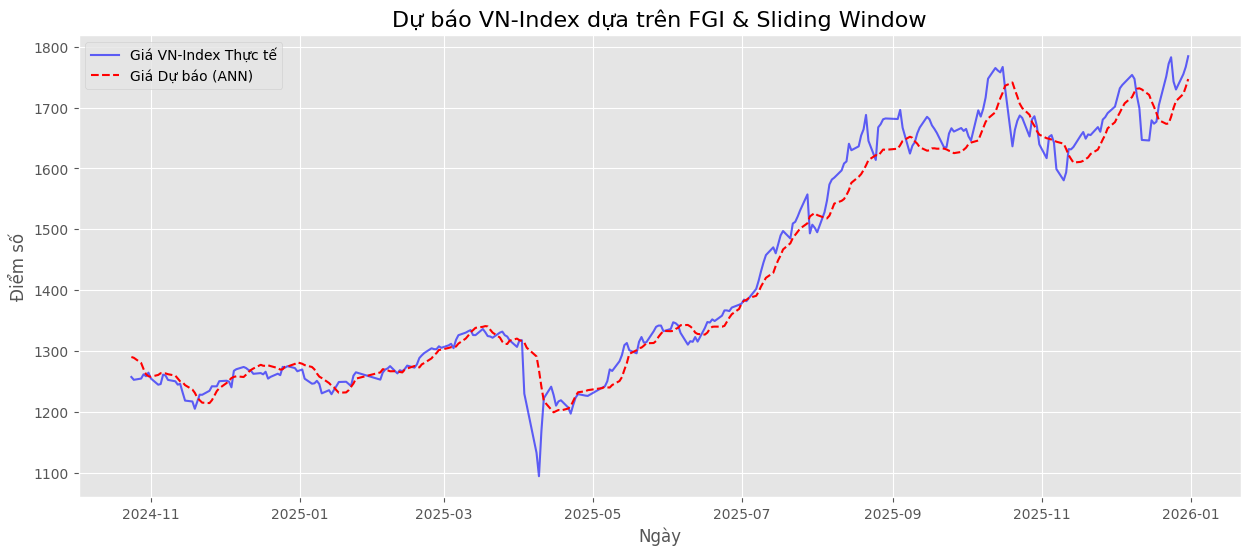

In [164]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = y_test_unscaled

# Tính toán các chỉ số
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"\n--- KẾT QUẢ ĐÁNH GIÁ ---")
print(f"RMSE: {rmse:.2f} điểm")
print(f"MAE: {mae:.2f} điểm")
print(f"R2 Score: {r2:.4f}")

# Vẽ biểu đồ kết quả
plt.figure(figsize=(15, 6))
dates = df['date'].iloc[split + WINDOW_SIZE:].values
plt.plot(dates, y_actual, label='Giá VN-Index Thực tế', color='blue', alpha=0.6)
plt.plot(dates, y_pred, label='Giá Dự báo (ANN)', color='red', linestyle='--')
plt.title("Dự báo VN-Index dựa trên FGI & Sliding Window", fontsize=16)
plt.xlabel("Ngày")
plt.ylabel("Điểm số")
plt.legend()
plt.show()